# Retrieve NetCDF and model gridded climate time-series for a watershed

### Case study:  the Sauk-Suiattle Watershed
<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Re-establish the paths to the mapping file
    3. Compute daily, monthly, and annual temperature and precipitation statistics
    4. Visualize precipitation results relative to the forcing data
    5. Visualize the time-series trends
    6. Save results back into HydroShare

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  Prepare HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [42]:
# silencing warning
import warnings
warnings.filterwarnings("ignore")

# data processing
import os
import pandas as pd, numpy as np, dask

# data migration library
#import ogh
#import ogh_xarray_landlab as oxl
from utilities import hydroshare
from ecohydrology_model_functions import run_ecohydrology_model, plot_results
from landlab import imshow_grid, CLOSED_BOUNDARY
InputFile = 'ecohyd_inputs.yaml'

# plotting and shape libraries
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: attempted relative import with no known parent package

In [ ]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

In [ ]:

import pandas as pd

import xarray as xr

import os as os

homedir = 'D:/UW_PhD/Python/xarray/'
os.chdir(homedir)

#open pnnl lat long el file
pnnlxy = xr.open_dataset('data_LatLonGht.nc')

#range of dates to create new files for
start_date = '2006-11-01'
end_date = '2006-11-20'

dates = [x.strftime('%Y-%m-%d') for x in pd.date_range(start=start_date, end=end_date, freq='D')]
#for each day (file) open pnnl netcdf file as xarray dataset, add coordinate data, save as new netcdf
for ind, ymd in enumerate(dates):
    date = ymd
    pnnl = xr.open_dataset('data.' + date +'.nc')


    #merge pnnl lat long data with climate data
    pnnlnew = xr.merge([pnnl, pnnlxy], compat='no_conflicts')

    #convert variables LAT, LON and Z to coordinates
    pnnlnewc = pnnlnew.set_coords({'LAT','LON','Z'}, inplace=False)

    #create series of dates to add to dataset
    time = pd.date_range(start=date, periods=24, freq='H')

    #add coordinates using series of dates
    pnnlnewc.update({'time': ('time', time)})


    #problem with xarray dataframe.to_netcdf method: does not work if attributes contain attribute titled "coordinates"; 
    #for variables that have coordinates in attributes, remove "coordinate" from attributes
    pnnlnewc.Q2.attrs = ([('stagger', ''),
                          ('units', 'kg kg-1'),
                          ('description', 'QV at 2 M'),
                          ('MemoryOrder', 'XY '),
                          ('FieldType', 104)])
    
    pnnlnewc.PSFC.attrs = ([('stagger', ''),
                            ('units', 'Pa'),
                            ('description', 'SFC PRESSURE'),
                            ('MemoryOrder', 'XY '),
                            ('FieldType', 104)])
    
    pnnlnewc.GLW.attrs = ([('stagger', ''),
                           ('units', 'W m-2'),
                           ('description', 'DOWNWARD LONG WAVE FLUX AT GROUND SURFACE'),
                           ('MemoryOrder', 'XY '),
                           ('FieldType', 104)])
    
    pnnlnewc.SWDOWN.attrs = ([('stagger', ''),
                              ('units', 'W m-2'),
                              ('description', 'DOWNWARD SHORT WAVE FLUX AT GROUND SURFACE'),
                              ('MemoryOrder', 'XY '),
                              ('FieldType', 104)])
    
    pnnlnewc.PREC_ACC_NC.attrs = ([('stagger', ''),
                                   ('units', 'mm'),
                                   ('description', 'GRID SCALE  PRECIPITATION'),
                                   ('MemoryOrder', 'XY '),
                                   ('FieldType', 104)])
    
    pnnlnewc.SNOW_ACC_NC.attrs = ([('stagger', ''),
                                   ('units', 'mm'),
                                   ('description', 'SNOW WATER EQUIVALENT'),
                                   ('MemoryOrder', 'XY '),
                                   ('FieldType', 104)])
    
    #save new netcdf file
    pnnlnewc.to_netcdf(date + '_coord.nc')
    print(str(ind) + ' : ' + date)

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [38]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 87dc5742cf164126a11ff45c3307fd9d
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong

The hs_utils library requires a secure connection to your HydroShare account.
Enter the HydroShare password for user 'jphuong': ········
Successfully established a connection with HydroShare


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

For visualization purposes, we will also remap the study site shapefile, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. Since the shapefile was previously migrated, we can select 'N' for no overwriting.

In the usecase1 notebook, the treatgeoself function identified the gridded cell centroid coordinates that overlap with our study site. These coordinates were documented within the mapping file, which will be remapped here. In the usecase2 notebook, the downloaded files were cataloged within the mapping file, so we will use the mappingfileSummary function to characterize the files available for Sauk-Suiattle for each gridded data product.

In [39]:
"""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']


"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource ef2d82bf960144b4bfb1bae6242bcc7f


This resource already exists in your userspace.
c532e0578e974201a0bc40a37ef2d284/
|-- c532e0578e974201a0bc40a37ef2d284/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.cpg
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shp
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.shx
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.dbf
|   |   |   |-- wbdhub12_17110006_WGS84_Basin.prj

Do you want to overwrite these data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


NameError: name 'ogh' is not defined

In [43]:
import geopandas as gpd
s1 = gpd.read_file(NAmer)
s1

,Lat,Long,Elev,geometry
0,52.96875,-67.03125,642.0,POINT Z (-67.03125 52.96875 642)
1,52.96875,-67.09375,606.0,POINT Z (-67.09375 52.96875 606)
2,52.96875,-67.15625,632.0,POINT Z (-67.15625 52.96875 632)
3,52.96875,-67.21875,622.0,POINT Z (-67.21875 52.96875 622)
4,52.96875,-67.28125,632.0,POINT Z (-67.28125 52.96875 632)
5,52.96875,-67.34375,623.0,POINT Z (-67.34375 52.96875 623)
6,52.96875,-67.40625,627.0,POINT Z (-67.40625 52.96875 627)
7,52.96875,-67.46875,623.0,POINT Z (-67.46875 52.96875 623)
8,52.96875,-67.53125,617.0,POINT Z (-67.53125 52.96875 617)
9,52.96875,-67.59375,610.0,POINT Z (-67.59375 52.96875 610)


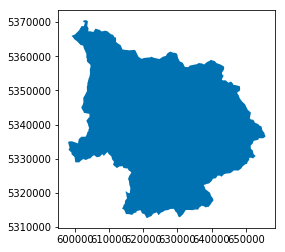

In [41]:
s1.plot()

### Summarize the file availability from each watershed mapping file

In [ ]:
%%time

# map the mappingfiles from usecase1
mappingfile1=ogh.treatgeoself(shapefile=sauk, NAmer=NAmer, buffer_distance=0.06,
                              mappingfile=os.path.join(homedir,'Sauk_mappingfile.csv'))

## 3.  Compare Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013 and Salathe 2014 mean temperature and mean total monthly precipitation in order to compare them with each other. The generated plots are automatically downloaded and saved as .png files within the "homedir" directory.

Let's compare the Livneh 2013 and Salathe 2014 using the period of overlapping history.

In [ ]:
help(ogh.getDailyMET_livneh2013)

In [ ]:
help(oxl.get_x_dailymet_Livneh2013_raw)

## NetCDF retrieval and clipping to a spatial extent

The function get_x_dailywrf_salathe2014 retrieves and clips NetCDF files archived within the UW Rocinante NNRP repository. This archive contains daily data from January 1970 through December 1979 (10 years). Each netcdf file is comprised of meteorologic and VIC hydrologic outputs for a calendar month. The expected number of files would be 360 files (12 months for 30 years). 

In the code chunk below, 40 parallel workers will be initialized to distribute file retrieval and spatial clipping tasks. For each worker, they will wget the requested file, clip the netcdf file to gridded cell centroids within the the provided bounding box, then return the location of the spatially clipped output files.

Provide the home and subdirectory where the cropped NetCDF files will be stored. Also provide the spatial bounds (in WGS84) to crop the NetCDF files upon download. Finally, provide the number of workers to carry out the download tasks, and the start and end date of the files of interest.

In [13]:
import os
import wget
import pandas as pd
import dask as da
import xarray as xray
import ogh_xarray_landlab as oxl
import sys

In [16]:
# getting the map
domain = 'http://cses.washington.edu'
subdomain = 'rocinante/WRF/PNNL_NARR_6km'
netcdfmap = 'data_LatLonGht.nc'

In [32]:
# retrieve the map
pnnlxy=xray.open_dataset(os.path.basename(netcdfmap))
pnnlxy

<xarray.Dataset>
Dimensions:  (south_north: 88, west_east: 75)
Dimensions without coordinates: south_north, west_east
Data variables:
    LAT      (south_north, west_east) float32 ...
    LON      (south_north, west_east) float32 ...
    Z        (south_north, west_east) float32 ...

In [46]:
for each in pnnlxy.LAT[0]:
    print(each.round(6))

<xarray.DataArray 'LAT' ()>
array(45.020408630371094, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.02798080444336, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.035499572753906, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.042972564697266, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.0504035949707, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.05778884887695, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.065120697021484, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.0723991394043, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.07963562011719, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.086814880371094, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.093955993652344, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.101043701171875, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.10810089111328, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.11508560180664, dtype=float32)
<xarray.DataArray 'LAT' ()>
array(45.122032

In [ ]:
# #merge pnnl lat long data with climate data
# pnnlnew = xr.merge([pnnl, pnnlxy], compat='no_conflicts')

# #convert variables LAT, LON and Z to coordinates
# pnnlnewc = pnnlnew.set_coords({'LAT','LON','Z'}, inplace=False)

In [28]:
start_date='1970-01-01'
end_date='1970-02-28'

dr = pd.date_range(start=start_date, end=end_date, freq='D')
dr

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10', '1970-01-11', '1970-01-12',
               '1970-01-13', '1970-01-14', '1970-01-15', '1970-01-16',
               '1970-01-17', '1970-01-18', '1970-01-19', '1970-01-20',
               '1970-01-21', '1970-01-22', '1970-01-23', '1970-01-24',
               '1970-01-25', '1970-01-26', '1970-01-27', '1970-01-28',
               '1970-01-29', '1970-01-30', '1970-01-31', '1970-02-01',
               '1970-02-02', '1970-02-03', '1970-02-04', '1970-02-05',
               '1970-02-06', '1970-02-07', '1970-02-08', '1970-02-09',
               '1970-02-10', '1970-02-11', '1970-02-12', '1970-02-13',
               '1970-02-14', '1970-02-15', '1970-02-16', '1970-02-17',
               '1970-02-18', '1970-02-19', '1970-02-20', '1970-02-21',
               '1970-02-22', '1970-02-23', '1970-02-24', '1970-02-25',
      

In [31]:
filelist = compile_x_wrfpnnl2018_raw_locations(dr,
                                               domain='http://cses.washington.edu',
                                               subdomain='rocinante/WRF/PNNL_NARR_6km')
filelist

['http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-01.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-02.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-03.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-04.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-05.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-06.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-07.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-08.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-09.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-10.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-11.nc',
 'http://cses.washington.edu/rocinante/WRF/PNNL_NARR_6km/1970/data.1970-01-12.nc',
 'ht

In [30]:
def compile_x_wrfpnnl2018_raw_locations(time_increments,
                                        domain='http://cses.washington.edu',
                                        subdomain='rocinante/WRF/PNNL_NARR_6km'):
    """
    Compile a list of file URLs for PNNL 2018 raw WRF data
    time_increments: (list) a list of dates that identify each netcdf file
    """
    locations=[]

    for ind, ymd in enumerate(time_increments):
        subfolder = '{0}'.format(ymd.strftime('%Y'))
        basename='data.{0}.nc'.format(ymd.strftime('%Y-%m-%d'))
        url='{0}/{1}/{2}/{3}'.format(domain, subdomain, subfolder, basename)
        locations.append(url)
    return(locations)

In [ ]:
def wget_netcdfmap_spSubset(url,
                            datetime,
                            spatialbounds,
                            netcdfmap=netcdfmap,
                            nworkers=20,
                            time_resolution='H',
                            time_steps=24,
                            file_prefix='sp_',
                            rename_timelatlong_names={'LAT':'LAT','LON':'LON'},
                            replace_file=True):
    
    # retrieve the file
    ogh.wget_download(url)
    
    # open the file
    ds = xray.open_dataset(os.path.basename(url), engine='netcdf4')

    #merge pnnl lat long data with climate data
    ds_new = xr.merge([ds, netcdfmap], compat='no_conflicts')

    #convert variables LAT, LON and Z to coordinates
    ds_c = ds_new.set_coords({'LAT','LON','Z'}, inplace=False)

    #create series of dates to add to dataset
    time_inc = pd.date_range(start=ymd, periods=time_steps, freq=time_resolution)

    #add coordinates using series of dates
    ds_c.update({'time': ('time', time_inc)})
    
    # rename latlong if they are not LAT and LON, respectively
    if not isinstance(rename_timelatlong_names, type(None)):
        ds_c = ds_c.rename(rename_timelatlong_names)

    # slice by the bounding box
    spSubset = ds_c.sel(LON=slice(spatialbounds['minx'], spatialbounds['maxx']),
                        LAT=slice(spatialbounds['miny'], spatialbounds['maxy']))

    # print the spatial subset
    spSubset.to_netcdf(file_prefix+os.path.basename(url))
    
    # remove the parent
    ds.close()
    os.remove(os.path.basename(url))
    return(os.path.join(os.getcwd(), file_prefix+os.path.basename(url)))

In [10]:
sorted(sys.modules.keys())

['IPython',
 'IPython.core',
 'IPython.core.alias',
 'IPython.core.application',
 'IPython.core.autocall',
 'IPython.core.builtin_trap',
 'IPython.core.compilerop',
 'IPython.core.completer',
 'IPython.core.completerlib',
 'IPython.core.crashhandler',
 'IPython.core.debugger',
 'IPython.core.display',
 'IPython.core.display_trap',
 'IPython.core.displayhook',
 'IPython.core.displaypub',
 'IPython.core.error',
 'IPython.core.events',
 'IPython.core.excolors',
 'IPython.core.extensions',
 'IPython.core.formatters',
 'IPython.core.getipython',
 'IPython.core.history',
 'IPython.core.hooks',
 'IPython.core.inputsplitter',
 'IPython.core.inputtransformer',
 'IPython.core.interactiveshell',
 'IPython.core.latex_symbols',
 'IPython.core.logger',
 'IPython.core.macro',
 'IPython.core.magic',
 'IPython.core.magic_arguments',
 'IPython.core.magics',
 'IPython.core.magics.auto',
 'IPython.core.magics.basic',
 'IPython.core.magics.code',
 'IPython.core.magics.config',
 'IPython.core.magics.display

In [8]:

if 'oxl' not in sys.modules:
    print(True)

True


In [ ]:
def get_netcdfmap_hourlywrf_PNNL2018(spatialbounds,
                                     homedir,
                                     subdir='PNNL2018/Hourly_WRF_1981_2015/noBC',
                                     start_date='1970-01-01',
                                     end_date='1970-02-28',
                                     nworkers=20):
    """
    get hourly WRF data from a 2018 PNNL WRF run using xarray on netcdf files
    """
    
    # check and generate data directory
    filedir=os.path.join(homedir, subdir)
    ogh.ensure_dir(filedir)

    locations=[]
    domain='http://cses.washington.edu'
    subdomain='rocinante/WRF/PNNL_NARR_6km'

    # initialize parallel workers
    da.set_options(pool=ThreadPool(nworkers))
    ProgressBar().register()
    
    # retrieve the netcdf map
    netcdfmap = 'data_LatLonGht.nc'
    if not os.path.exists(netcdfmap):
        wget.download('{0}/{1}/{2}'.format(domain, subdomain, netcdfmap))
    pnnlxy=xray.open_dataset(netcdfmap)

    # retrieve data files
    dr = pd.date_range(start=start_date, end=end_date, freq='D')

    # map to the data files
    locations = compile_x_wrfpnnl2018_raw_locations(time_increments=dr,
                                                    domain=domain,
                                                    subdomain=domain)
    
    # retrieve and subset each netcdf datafile
    for eachurl in locations:
        pnnl_files=append(da.delayed(wget_netcdfmap_spSubset)(url=eachurl,
                                                              datetime=ymd,
                                                              spatialbounds=spatialbounds,
                                                              netcdfmap=netcdfmap,
                                                              nworkers=nworkers,
                                                              time_resolution='H',
                                                              file_prefix='sp_',
                                                              rename_timelatlong_names={'LAT':'LAT','LON':'LON'},
                                                              replace_file=True))
    # execute retrieval and spSubsetting
    pnnl_spSubset = da.compute(pnnl_files)[0]
    return(pnnl_spSubset)

In [ ]:
maptable, nstations = ogh.mappingfileToDF(mappingfile1)
spatialbounds = {'minx':maptable.LONG_.min(), 'maxx':maptable.LONG_.max(),
                 'miny':maptable.LAT.min(), 'maxy':maptable.LAT.max()}

outputfiles = oxl.get_x_dailymet_Livneh2013_raw(homedir=homedir,
                                                subdir='livneh2013/Daily_MET_1970_1970/raw_netcdf',
                                                spatialbounds=spatialbounds,
                                                nworkers=6,
                                                start_date='1970-01-01', end_date='1970-12-31')

### Convert collection of NetCDF files into a collection of ASCII files

Provide the home and subdirectory where the ASCII files will be stored, the source_directory of netCDF files, and the mapping file to which the resulting ASCII files will be cataloged. Also, provide the Pandas Datetime code for the frequency of the time steps. Finally, provide the catalog label that will be used for the mapping file catalog and the metadata file label.

In [ ]:
%%time
# convert the netCDF files into daily ascii time-series files for each gridded location
outfilelist = oxl.netcdf_to_ascii(homedir=homedir, 
                                  subdir='livneh2013/Daily_MET_1970_1970/raw_ascii', 
                                  source_directory=os.path.join(homedir, 'livneh2013/Daily_MET_1970_1970/raw_netcdf'),
                                  mappingfile=mappingfile1,
                                  temporal_resolution='D',
                                  meta_file=meta_file,
                                  catalog_label='sp_dailymet_livneh_1970_1970')

In [ ]:
t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1], 
                            listofwatershednames = ['Sauk-Suiattle river'],
                            meta_file=meta_file)

t1

In [ ]:
# Save the metadata
ogh.saveDictOfDf(dictionaryObject=meta_file, outfilepath='test.json')

### Create a dictionary of climate variables for the long-term mean (ltm).
#### INPUT: gridded meteorology ASCII files located from the Sauk-Suiattle Mapping file. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>OUTPUT: dictionary of dataframes where rows are temporal summaries and columns are spatial summaries

In [ ]:
meta_file['sp_dailymet_livneh_1970_1970']['variable_list']

In [ ]:
%%time

ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                        metadata=meta_file,
                        dataset='sp_dailymet_livneh_1970_1970',
                        variable_list=['Prec','Tmax','Tmin'])

sorted(ltm.keys())

### Compute the total monthly and yearly precipitation, as well as the mean values across time and across stations
#### INPUT: daily precipitation for each station from the long-term mean dictionary (ltm) <br/>OUTPUT: Append the computed dataframes and values into the ltm dictionary

In [ ]:
# extract metadata
dr = meta_file['sp_dailymet_livneh_1970_1970']

# compute sums and mean monthly an yearly sums
ltm = ogh.aggregate_space_time_sum(df_dict=ltm,
                                   suffix='Prec_sp_dailymet_livneh_1970_1970',
                                   start_date=dr['start_date'],
                                   end_date=dr['end_date'])

In [ ]:
# print the name of the analytical dataframes and values within ltm
sorted(ltm.keys())

In [ ]:
# initialize list of outputs
files=[]

# create the destination path for the dictionary of dataframes
ltm_sauk=os.path.join(homedir, 'ltm_1970_1970_sauk.json')
ogh.saveDictOfDf(dictionaryObject=ltm, outfilepath=ltm_sauk)
files.append(ltm_sauk)

# append the mapping file for Sauk-Suiattle gridded cell centroids
files.append(mappingfile1)

### Visualize the "average monthly total precipitations"

#### INPUT: dataframe with each month as a row and each station as a column. <br/>OUTPUT: A png file that represents the distribution across stations (in Wateryear order)

In [ ]:
# # two lowest elevation locations
lowE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=164)

# one highest elevation location
highE_ref = ogh.findCentroidCode(mappingfile=mappingfile1, colvar='ELEV', colvalue=2216)

# combine references together
reference_lines = highE_ref + lowE_ref
reference_lines


In [ ]:
ogh.renderValueInBoxplot(ltm['meanbymonthsum_Prec_sp_dailymet_livneh_1970_1970'],
                         outfilepath='totalMonthlyRainfall.png', 
                         plottitle='Total monthly rainfall',
                         time_steps='month',
                         wateryear=True,
                         reference_lines=reference_lines,
                         ref_legend=True,
                         value_name='Total daily precipitation (mm)',
                         cmap='seismic_r',
                         figsize=(6,6))

In [ ]:
ogh.renderValuesInPoints(ltm['meanbymonthsum_Prec_sp_dailymet_livneh_1970_1970'], 
                         vardf_dateindex=12, 
                         shapefile=sauk, 
                         cmap='seismic_r',
                         outfilepath='test.png', 
                         plottitle='December total rainfall',
                         colorbar_label='Total monthly rainfall (mm)', 
                         figsize=(1.5,1.5))

In [ ]:
minx2, miny2, maxx2, maxy2 = oxl.calculateUTMbounds(mappingfile=mappingfile1,
                                                    mappingfile_crs={'init':'epsg:4326'},
                                                    spatial_resolution=0.06250)

print(minx2, miny2, maxx2, maxy2)

# generate a raster

In [ ]:
help(oxl.rasterDimensions)

In [ ]:
# generate a raster
raster, row_list, col_list = oxl.rasterDimensions(minx=minx2, miny=miny2, maxx=maxx2, maxy=maxy2, dx=1000, dy=1000)
raster.shape

# Higher resolution children of gridded cells 
### get data from Lower resolution parent grid cells to the children

In [ ]:
help(oxl.mappingfileToRaster)

In [ ]:
%%time

# landlab raster node crossmap to gridded cell id
nodeXmap, raster, m = oxl.mappingfileToRaster(mappingfile=mappingfile1, spatial_resolution=0.06250, 
                                           minx=minx2, miny=miny2, maxx=maxx2, maxy=maxy2, dx=1000, dy=1000)

In [ ]:
# print the raster dimensions
raster.shape

In [ ]:
%%time
nodeXmap.plot(column='ELEV', figsize=(10,10), legend=True)

In [ ]:
# generate vector array of December monthly precipitation
prec_vector = ogh.rasterVector(vardf=ltm['meanbymonthsum_Prec_sp_dailymet_livneh_1970_1970'],
                          vardf_dateindex=12,
                          crossmap=nodeXmap,
                          nodata=-9999)

# close-off areas without data
raster.status_at_node[prec_vector==-9999] = CLOSED_BOUNDARY

fig =plt.figure(figsize=(10,10))
imshow_grid(raster, 
            prec_vector,
            var_name='Daily precipitation',
            var_units=meta_file['sp_dailymet_livneh_1970_1970']['variable_info']['Prec'].attrs['units'],
            color_for_closed='black', 
            cmap='seismic_r')

In [ ]:
tmax_vector = ogh.rasterVector(vardf=ltm['meanbymonth_Tmax_sp_dailymet_livneh_1970_1970'],
                          vardf_dateindex=12,
                          crossmap=nodeXmap,
                          nodata=-9999)

fig = plt.figure(figsize=(10,10))
imshow_grid(raster, 
            tmax_vector,
            var_name='Daily maximum temperature',
            var_units=meta_file['sp_dailymet_livneh_1970_1970']['variable_info']['Tmax'].attrs['units'],
            color_for_closed='black', symmetric_cbar=False, cmap='magma')

In [ ]:
tmin_vector = ogh.rasterVector(vardf=ltm['meanbymonth_Tmin_sp_dailymet_livneh_1970_1970'],
                          vardf_dateindex=12,
                          crossmap=nodeXmap,
                          nodata=-9999)

fig = plt.figure(figsize=(10,10))
imshow_grid(raster, 
            tmin_vector,
            var_name='Daily minimum temperature',
            var_units=meta_file['sp_dailymet_livneh_1970_1970']['variable_info']['Tmin'].attrs['units'],
            color_for_closed='black', symmetric_cbar=False, cmap='magma')

In [ ]:
# convert a raster vector back to geospatial presentation
t4, t5 = rasterVectorToWGS(prec_vector, nodeXmap=nodeXmap, UTM_transformer=m)

In [ ]:
t4.plot(column='value', figsize=(10,10), legend=True)

In [ ]:
# this is one decade
inputvectors = {'precip_met': np.tile(ltm['meandaily_Prec_sp_dailymet_livneh_1970_1970'], 15000),
                'Tmax_met': np.tile(ltm['meandaily_Tmax_sp_dailymet_livneh_1970_1970'], 15000),
                'Tmin_met': np.tile(ltm['meandaily_Tmin_sp_dailymet_livneh_1970_1970'], 15000)}

In [ ]:
%%time
(VegType_low, yrs_low, debug_low) = run_ecohydrology_model(raster,
                                                           input_data=inputvectors,
                                                           input_file=InputFile,
                                                           synthetic_storms=False,
                                                           number_of_storms=100000,
                                                           pet_method='PriestleyTaylor')

In [ ]:
plot_results(raster, VegType_low, yrs_low, yr_step=yrs_low-1)
plt.show()
plt.savefig('grid_low.png')

### Visualize the "average monthly total precipitation"

## 5. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

### Total files and image to migrate

In [ ]:
len(files)

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Computed spatial-temporal summaries of two gridded data product data sets for Sauk-Suiattle'
abstract = 'This resource contains the computed summaries for the Meteorology data from Livneh et al. 2013 and the WRF data from Salathe et al. 2014.'
keywords = ['Sauk-Suiattle', 'Livneh 2013', 'Salathe 2014','climate','hydromet','watershed', 'visualizations and summaries'] 
rtype = 'genericresource'

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)